<!-- ph: Phragmites australis

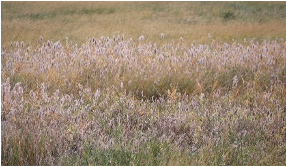

su: Suaeda salsa

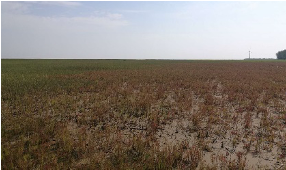

sp: Spartina alterniflora 

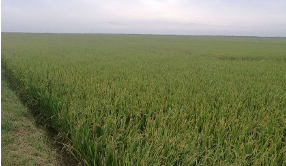 -->

In [1]:
%reset -f

In [2]:
#packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Widening the screen
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
FS=25
rcParams['figure.dpi'] = 1800
rcParams['savefig.dpi'] = 800
rcParams['font.size'] = FS
rcParams['font.family'] = 'StixGeneral'
rcParams["mathtext.fontset"] = 'stix'
# rcParams["mathtext.default"] = "rm" 
# rcParams['xtick.direction'] = 'in'
plt.rc('font', size=FS)          # controls default text sizes
plt.rc('axes', titlesize=FS)     # fontsize of the axes title
plt.rc('axes', labelsize=FS)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FS)    # fontsize of the tick labels
plt.rc('legend', fontsize=FS)    # legend fontsize
plt.rc('figure', titlesize=FS)   # fontsize of the figure title

In [4]:
#grid
LX =435
LT =31#1990-2020
dx =1.0
dt =0.001

<!-- A12=A21 芦苇和碱蓬

A32=A23 互花米草和碱蓬

A31?A13 芦苇？互花米草 -->

In [5]:
#parameter
#Ph: N1
D1  =162.0
A11 =1.0
A21 =0.917
A31 =0.962

#Su: N2
D2  =10.0
A12 =1.0
A22 =1.0
A32 =1.0

#Sp: N3
D3  =78.5
A13 =1.0
A23 =0.984
A33 =1.0

R1  =np.zeros(LX)+1.0
R2  =np.zeros(LX)+1.0
R3  =np.zeros(LX)+1.0
R1[30:180] =R1[30:180]-np.linspace(1,0,150)
R2[30:180] =R2[30:180]-np.linspace(1,0,150)
R3[30:60]  =R3[30:60] -np.linspace(1,0,30)
R1[0:30] =0.0
R2[0:30] =0.0
R3[0:30] =0.0

In [6]:
#import data
import pandas
# area
df = pandas.read_csv('./Data S1 Percent cover.csv',header=0)
df1990   = df[df.Year == 1990]
df1990ph = df1990[df1990.Vegetation == 'ph']#
df1990su = df1990[df1990.Vegetation == 'su']
df1990sp = df1990[df1990.Vegetation == 'sp']

In [7]:
# salinity
dfe = pandas.read_csv('./Data S2 Salinity.csv',header=0)

In [8]:
# Salinity Before 1990
from numpy import polyfit, poly1d
dfe1990   = dfe[dfe['Year']<1990]
x1990     = dfe1990.Distance 
y1990     = dfe1990.Salinity
# polyfit
coeff1990 = polyfit(x1990, y1990, 1)
print(coeff1990)
# predict
f1990     = poly1d(coeff1990)
xnew1990  = np.linspace(0.0, (435.0-1.0)*30.0/1000.0,LX)
ynew1990  = f1990(xnew1990)

[0.02630668 0.62144737]


In [9]:
#initial value
N0 = 1.0
N1 = np.flipud( df1990ph.Percent_cover ) #Phragmites australis
N2 = np.flipud( df1990su.Percent_cover ) #Suaeda salsa
N3 = np.flipud( df1990sp.Percent_cover ) #Spartina alterniflora 

Ma = np.zeros((LT,LX))
Mb = np.zeros((LT,LX))
Mc = np.zeros((LT,LX))
Me = np.zeros((LT,LX))

In [10]:
#diffuse
def d2_dx2(Z): 
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    return (Zleft + Zright - 2.0 * Z) / dx**2

In [11]:
def d_dx(Z): # First order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zcenter = Z[:]
    return (Zcenter - Zleft) / dx

# simulation

In [12]:
a = 0.2
b = 1.0
c = np.flipud(ynew1990)
d = 0.1
e = 0.18
f = 0.02

In [13]:
np.mean(ynew1990)

0.7927038609254118

In [14]:
npoint = 100
npointE = 2

CC = np.linspace(0.0,5.0,npoint)
EE = np.linspace(0.0,0.18,2)

PhMean = np.zeros((npointE,npoint))
SuMean = np.zeros((npointE,npoint))
SpMean = np.zeros((npointE,npoint))

SuiC = 0
for cCC in CC:
    SuiE = 0
    for e in EE:
        #main simulation
        N1     = np.flipud( df1990ph.Percent_cover )
        N2     = np.flipud( df1990su.Percent_cover )
        N3     = np.flipud( df1990sp.Percent_cover )
        E      = np.flipud( ynew1990 )
        Ma     =np.zeros((LT,LX))
        Mb     =np.zeros((LT,LX))
        Mc     =np.zeros((LT,LX))
        Me     =np.zeros((LT,LX))
        for j in range(int(LT)):
            Ma[j,:] = N1
            Mb[j,:] = N2
            Mc[j,:] = N3
            Me[j,:] = E
            for i in range(int(1/dt)):
                a12 = (A12/(E+a))
                N1, N2, N3,E = \
                N1 + dt*( D1*d2_dx2(N1) + N1*(R1-A11*N1-A21*N2-A31*N3) ),\
                N2 + dt*( D2*d2_dx2(N2) + N2*(R2-a12*N1-A22*N2-A32*N3) ),\
                N3 + dt*( D3*d2_dx2(N3) + N3*(R3-A13*N1-A23*N2-A33*N3) + 6.2*d_dx(N3) ),\
                E  + dt*( f*(cCC - E) + d*N3/(b+N3)*E - e*np.sum(N3)/LX*E )

                #boundary conditions
                N1[0]=N1[1]
                N1[LX-1]=N1[LX-2]
                N2[0]=N2[1]
                N2[LX-1]=N2[LX-2]
                N3[0]=N3[1]
                N3[LX-1]=N3[LX-2]
                E[0]=E[1]
                E[LX-1]=E[LX-2]
        PhMean[SuiE,SuiC] = np.mean(N1)
        SuMean[SuiE,SuiC] = np.mean(N2)
        SpMean[SuiE,SuiC] = np.mean(N3)
        SuiE = SuiE+1
    SuiC = SuiC+1
print(SuiE,SuiC,SuMean)

2 100 [[0.02444518 0.02954554 0.03537506 0.0419515  0.04927933 0.05735109
  0.06614898 0.07564637 0.08580905 0.09659594 0.10795964 0.11984662
  0.13219749 0.14494735 0.15802647 0.1713613  0.18487596 0.19849397
  0.21214022 0.22574297 0.23923563 0.25255823 0.26565852 0.27849246
  0.29102438 0.30322671 0.31507939 0.32656914 0.33768855 0.34843523
  0.35881087 0.36882046 0.37847158 0.38777375 0.39673789 0.40537588
  0.41370025 0.42172382 0.42945954 0.4369203  0.44411879 0.45106743
  0.45777828 0.46426298 0.47053274 0.47659828 0.4824698  0.48815695
  0.4936688  0.49901376 0.50419959 0.50923331 0.51412114 0.5188685
  0.52347997 0.52795927 0.53230927 0.53653206 0.54062903 0.54460097
  0.54844819 0.55217072 0.55576843 0.55924121 0.56258913 0.56581253
  0.56891214 0.57188917 0.57474527 0.57748261 0.58010381 0.58261191
  0.58501033 0.58730278 0.58949318 0.59158565 0.59358439 0.59549364
  0.59731763 0.59906056 0.60072651 0.60231946 0.60384327 0.60530163
  0.60669806 0.60803593 0.60931843 0.610548

# save data

In [15]:
# import pandas as pd
# np.save('ParsAnalysis_C_CC.npy',CC)
# np.save('ParsAnalysis_C_PhMean.npy',PhMean)
# np.save('ParsAnalysis_C_SuMean.npy',SuMean)
# np.save('ParsAnalysis_C_SpMean.npy',SpMean)

In [16]:
# CC=np.load('ParsAnalysis_C_CC.npy')
# PhMean=np.load('ParsAnalysis_C_PhMean.npy')
# SuMean=np.load('ParsAnalysis_C_SuMean.npy')
# SpMean=np.load('ParsAnalysis_C_SpMean.npy')

# Plot

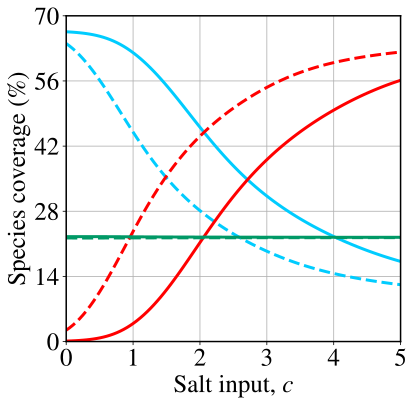

In [17]:
nticker = 6
from matplotlib import ticker
fig1, ax = plt.subplots(1, 1, figsize=(6, 6))
# line10, = ax.plot(CC, PhMean[0,:]*100, lw=2, color='b', label='P. a. (e=0.0)'); 
# line20, = ax.plot(CC, PhMean[1,:]*100, lw=2, color='b', linestyle='--', label='P. a. (e=0.15)'); 
# line11, = ax.plot(CC, SuMean[0,:]*100, lw=2, color='r', label='S. s. (e=0.0)'); 
# line21, = ax.plot(CC, SuMean[1,:]*100, lw=2, color='r', linestyle='--', label='S. s. (e=0.15)'); 
# line12, = ax.plot(CC, SpMean[0,:]*100, lw=2, color='g', label='S. a. (e=0.0)'); 
# line22, = ax.plot(CC, SpMean[1,:]*100, lw=2, color='g', linestyle='--', label='S. a. (e=0.15)');
line10, = ax.plot(CC, PhMean[0,:]*100, lw=3, color='#00CCFF', linestyle='--', label='P. a. (e=0.0)'); 
line20, = ax.plot(CC, PhMean[1,:]*100, lw=3, color='#00CCFF', label='P. a. (e=0.07)'); 
line11, = ax.plot(CC, SuMean[0,:]*100, lw=3, color='r', linestyle='--', label='S. s. (e=0.0)'); 
line21, = ax.plot(CC, SuMean[1,:]*100, lw=3, color='r', label='S. s. (e=0.07)'); 
line12, = ax.plot(CC, SpMean[0,:]*100, lw=3, color='#009966', linestyle='--', label='S. a. (e=0.0)'); 
line22, = ax.plot(CC, SpMean[1,:]*100, lw=3, color='#009966', label='S. a. (e=0.07)');

ax.set_xlim(0.0, 5.0)
ax.set_xticks(np.linspace(0.0,5.0,nticker))

ax.set_ylim(0.0, 70)
ax.set_yticks(np.linspace(0.0, 70,nticker))

ax.set_xlabel('Salt input, $c$');
ax.set_ylabel('Species coverage (%)');

ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);

# ax.legend(fontsize=12)
ax.grid()
fig1.savefig('FIgure S5c Sensitivity analysisParC.pdf',bbox_inches='tight')

© 2021, Kang Zhang, ECNU. Follow Johan van de Koppel & Quan-Xing Liu.